## Stereomer search

The first important part of the MACE package's functionality is a stereomer search:

In [1]:
# use current mace version
import sys, os
sys.path.insert(0, os.path.abspath('../../../'))

# imports
import mace, py3Dmol
from rdkit import Chem

# view 3D structures
def view_complex(X, confId = 0):
    '''Shows molecule corresponding to the SMILES'''
    view = py3Dmol.view()
    view.addModel(X.ToXYZBlock(confId = confId), 'xyz')
    view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.3}})
    view.setBackgroundColor('white')
    view.zoomTo()
    view.show()

In [2]:
# generate conformers for RuCl2(en)2
ligands = ['[NH2:1]CC[NH2:1]', '[NH2:1]CC[NH2:1]', '[Cl-:1]', '[Cl-:1]']
X = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
Xs = X.GetStereomers()
len(Xs)

2

In [3]:
# get conformers and indexes of minimal energy conformers
for X in Xs:
    X.AddConformers(numConfs = 5)
emin_idxs = [X.GetMinEnergyConfId(0) for X in Xs]

# view
for i, X in enumerate(Xs):
    print(f'Stereomer #{i}')
    view_complex(Xs[i], confId = emin_idxs[i])

Stereomer #0


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Stereomer #1


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Further in this section we will review the main parameters of stereomer search and some important usage scenarios.

### Stereochemistry control

There are three regimes stereomer search (`regime` parameter):

* "all": default choice, changes stereochemistry of all undefined stereocenters.

* "ligands": changes stereochemistry of undefined stereocenters in ligands only, ignores central atom;

* "CA": changes stereochemistry of the central atom only, ignores undefined stereocenters in ligands;

Pretty obvious, that the default `all` regime can be used in almost any situation.

#### Ligands-only regime

`ligands` regime can be useful if one want to fix stereochemistry of the central atom. This can be the case for ligands containing aliphatic amine donor group with three different substituents, which will form a chiral center after binding to the metal:

In [4]:
# get stereomers
ligands = ['C[N:1](C)CC[N:2](C)CC[P:3](C)C', '[C-:4]#[O+]', '[H-:5]', '[H-:6]']
X = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
Xs = X.GetStereomers(regime = 'ligands')
len(Xs)

2

In [5]:
# get conformers
for X in Xs:
    X.AddConformers(numConfs = 3)
emin_idxs = [X.GetMinEnergyConfId(0) for X in Xs]

# view
for i, X in enumerate(Xs):
    print(f'Stereomer #{i}')
    view_complex(Xs[i], confId = emin_idxs[i])

Stereomer #0


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Stereomer #1


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

How one can see, the difference between those two complexes are the stereo-configuration of the central nitrogen of the PNN ligand, which is not present in the isolated ligand.

#### Central-atom-only regime

The only situation when this regime can be used effectively is the case of rigid poly-dentate ligands containing several (potentially) stereogenic centers of unknown configuration. In this case the `CA` regime will generate mainly possible stereomers and will ignore "impossible" structures:

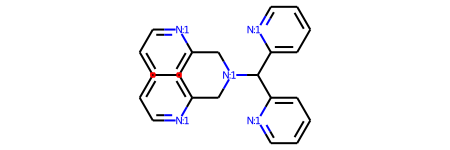

In [6]:
# check ligand
smiles = 'c1cc[n:1]c(C[N:1](Cc2cccc[n:1]2)C(c2cccc[n:1]2)c2cccc[n:1]2)c1'
Chem.MolFromSmiles(smiles)

In [7]:
# get 'all' stereomers
X = mace.ComplexFromLigands([smiles, '[H-:1]'], '[Mn+]', 'OH')
Xs_all = X.GetStereomers(regime = 'all')
len(Xs_all)

5

In [8]:
# get 'CA' stereomers
Xs_CA = X.GetStereomers(regime = 'CA')
len(Xs_CA)

2

In [9]:
# get 3D coords and view
for i, X in enumerate(Xs_CA):
    X.AddConformer()
    print(f'Stereomer #{i}: {X.GetNumConformers()} confs')
    if X.GetNumConformers():
        view_complex(X)

Stereomer #0: 1 confs


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Stereomer #1: 0 confs


Absence of generated conformers can be considered as an evidence of its "impossibility", or rather its high energy. Also note, that if original ligands has undefined stereocenters, than conformers obtained for `CA`-generated stereomers can be diastereomers, not conformers.

#### Enantiomers

The other parameter controlling stereochemistry is `dropEnantiomers`. If `True`, it reduces pairs of enantiomers to one complex:

In [10]:
# get complex
ligands = ['[NH2:1]CC[NH2:1]', '[NH2:1]CC[NH2:1]', '[NH2:1]CC[NH2:1]']
X = mace.ComplexFromLigands(ligands, '[Ru+2]', 'OH')

# check number of stereomers
print(f'Number of stereomers without enantiomers: {len(X.GetStereomers(dropEnantiomers = True))}')
print(f'Number of stereomers with enantiomers: {len(X.GetStereomers(dropEnantiomers = False))}')

Number of stereomers without enantiomers: 1
Number of stereomers with enantiomers: 2


Consideration of both enantiomers may be necessary only if the complex is in a chiral environment that is not its ligand, which is quite rare for homogeneous catalysis.

### Rule-based filtering

Unlike monodentate ligands, relative positions of donor atoms in complexes of chelates and multidentate ligands are restricted by the ligand's structure.

#### minTransCycle

The most obvious scenario is coordination of bidentate ligand: unless the ligand is "long", donor atoms can not be in *trans-* position to each other. In MACE, this idea is controlled by the `minTransCycle` parameter, which is the minimal size of the ..DA->M<-DA.. cycle, where DA are in trans- position to each other and belong to one ligand:

In [11]:
# get stereomers
ligands = ['[NH2:1]CCOCCOCCOCC[NH2:1]', '[Cl-:1]', '[Cl-:1]']
X = mace.ComplexFromLigands(ligands, '[Pt+2]', 'SP')
print(f'Number of stereomers with "trans-cycles" forbidden: {len(X.GetStereomers(minTransCycle = None))}')

# get stereomers with allowed "trans-cycles"
Xs = X.GetStereomers(minTransCycle = 12)
print(f'Number of stereomers with "trans-cycles" allowed: {len(Xs)}')

Number of stereomers with "trans-cycles" forbidden: 1
Number of stereomers with "trans-cycles" allowed: 2


In [12]:
# get conformers
for X in Xs:
    X.AddConformers(numConfs = 10)
emin_idxs = [X.GetMinEnergyConfId(0) for X in Xs]

# view
for i, X in enumerate(Xs):
    print(f'Stereomer #{i}')
    view_complex(Xs[i], confId = emin_idxs[i])

Stereomer #0


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Stereomer #1


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### merRule

`merRule` is another similar parameter. It restricts "rigid" DA-DA-DA fragments (e.g. terpyridine) to be in meridial conformation:

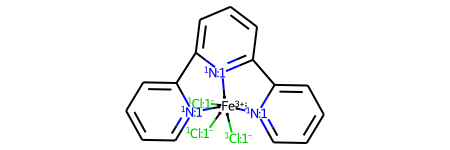

In [13]:
# get complex
ligands = ['[n:1]1ccccc1-c([n:1]1)cccc1-c1cccc[n:1]1', '[Cl-:1]', '[Cl-:1]', '[Cl-:1]']
X = mace.ComplexFromLigands(ligands, '[Fe+3]', 'OH')
X.mol

In [14]:
# check number of stereomers
print(f'Number of stereomers with merRule: {len(X.GetStereomers(merRule = True))}')
print(f'Number of stereomers without merRule: {len(X.GetStereomers(merRule = False))}')

Number of stereomers with merRule: 1
Number of stereomers without merRule: 2


In most cases merRule nicely filters "impossible" stereomers, though experience shows that in some cases it throws out energetically possible structures due to simplicity of the "rigidity"-determining algorithm, and its applicability for the systems under study should be analyzed carefully:

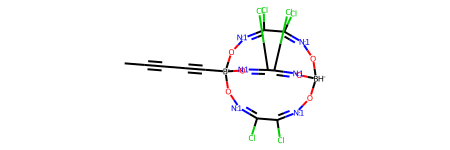

In [15]:
# check ligand structure
smiles = 'CC#CC#C[B-]12O[N:1]=C(Cl)C(Cl)=[N:1]O[BH-](O[N:1]=C(Cl)C(Cl)=[N:1]O1)O[N:1]=C(Cl)C(Cl)=[N:1]O2'
Chem.MolFromSmiles(smiles)

In [16]:
# get stereomers with merRule
X = mace.ComplexFromLigands([smiles], '[Fe+2]', 'OH')
Xs = X.GetStereomers(merRule = True)
print(f'Number of stereomers with merRule: {len(Xs)}')

# get stereomers without merRule
Xs = X.GetStereomers(regime = 'CA', merRule = False) # "CA" to ignore double bonds
print(f'Number of stereomers with merRule: {len(Xs)}')

Number of stereomers with merRule: 0
Number of stereomers with merRule: 1


In [17]:
# get 3D and view
X = Xs[0]
X.AddConformer()
view_complex(X)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Please note, that we also used the `CA` regime here to ignore stereochemistry of double bonds, which is considered by the `all` regime. <span style="color: #EAECEE">And this complex is how the author of mace sees the EPIC MACE, if you were wandering.</span>